<a href="https://colab.research.google.com/github/SajaZenaty/code_mate/blob/main/AskPy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 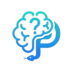**AskPy — Python AI Tutor**

AskPy is an interactive application that leverages **Semantic Information Retrieval (RAG)** and modern language models to provide:

- Clear explanations of Python concepts.

- Ready-made examples from our database.

The application acts as a smart Python tutor; you can ask it anything, and it will search its internal database, extract the best context, and generate a suitable answer.

🔗 [LinkedIn Post](https://www.linkedin.com/posts/leen-shaikhibrahim_ai-rag-llm-activity-7401226179820634113-upWi?utm_source=share&utm_medium=member_desktop&rcm=ACoAAFss9NwB60PgigPWP_ZdLK5KTVvgXNAkxNY)  
🚀 [Demo](https://drive.google.com/file/d/1LFBNkrQLOIjqsgEQpknzIoDpYg47GjHg/view?usp=sharing)

In the following sections, we will set up the environment, load the data, create the vector store, and build a complete Streamlit interface.

## ⚙️ Setting Up the Environment and Installing Requirements
In this step, we install all the necessary libraries and tools to run the RAG app, including:
- **Streamlit** library for building the user interface.

- **Sentence Transformers** and **FAISS** libraries for building the semantic retrieval system (RAG).

- **pyngrok** to run the app and connect it to a public domain.

This step is essential for the application to run smoothly within Google Colab.

In [ ]:
!apt-get install -y libmagic1 --quiet
!pip install streamlit --quiet
!pip install sentence-transformers faiss-cpu --quiet
!pip install pyngrok --quiet

Reading package lists...
Building dependency tree...
Reading state information...
libmagic1 is already the newest version (1:5.41-3ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


## 🔐 Setting up ngrok to obtain a public link for the application

In this section, we request the ngrok service token from the user and register it so that Streamlit can work on an accessible external link.

- Token entry is done securely using `getpass`.

- We use `ngrok.set_auth_token()` to store the token within the session.

In [ ]:
from getpass import getpass
from pyngrok import ngrok

token = getpass("Enter your ngrok token: ")
ngrok.set_auth_token(token)

Enter your ngrok token: ··········


## 📂 Uploading Data from Google Drive

In this step, we:

- Connect Google Drive to access the project files.

- Upload the data file `data_py.json` containing the content used within the RAG.

- Upload the application icon `icon.png` and a small transparent image to use as an avatar.

This cell prepares the project files before running the application.

In [ ]:
from google.colab import drive
import json
import os
from PIL import Image

drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/AskPy/data_py.json"
icon_path = "/content/drive/MyDrive/AskPy/icon.png"
trans_path = "/content/drive/MyDrive/AskPy/trans.png"

with open(file_path, "r", encoding="utf-8") as f:
    dataset = json.load(f)

# Resize the transparent image to 1x1 pixels to ensure it functions as just empty space.

img = Image.open(trans_path)
img = img.resize((1, 1), Image.Resampling.LANCZOS)
img.save(trans_path)

# Verify the number of documents uploaded

print(f"Loaded {len(dataset)} documents")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 1781 documents


## 🧠 Creating an AskPy app within the `app.py` file

In this cell, we write the core app, which includes:

- Loading and preparing documents.

- Creating embedded files and building a search index using FAISS.

- Loading the language model to generate answers.

- Retrieving the best context for the question based on vectors.

- Building an interactive chat interface using Streamlit.

This cell contains all the application logic and runs it as a complete RAG interface.

In [ ]:
%%writefile app.py
import json
import streamlit as st
import numpy as np

# Embeddings
from sentence_transformers import SentenceTransformer
import faiss

# HuggingFace generation
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline


# ---------------------- Load Docs ----------------------
icon_path = "/content/drive/MyDrive/AskPy/icon.png"
trans_path = "/content/drive/MyDrive/AskPy/trans.png"
file_path = "/content/drive/MyDrive/AskPy/data_py.json"

def load_docs(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        raw = json.load(f)

    docs = []
    for d in raw:
        title = d.get("title", "")
        content = d.get("content", "")
        examples = d.get("example", "")

        if isinstance(examples, list):
            examples_text = "\n".join(examples)
        elif isinstance(examples, str):
            examples_text = examples
        else:
            examples_text = ""

        full = f"{title}\n\n{content}"
        if examples_text:
            full += f"\n\nExamples:\n{examples_text}"

        docs.append(full)

    return docs



# ---------------------- Embeddings + Index ----------------------
@st.cache_resource
def load_embedder():
    model = SentenceTransformer("all-MiniLM-L6-v2")
    return model


@st.cache_resource
def build_index(docs):
    embedder = load_embedder()
    vecs = embedder.encode(docs, convert_to_numpy=True)
    vecs = vecs / np.linalg.norm(vecs, axis=1, keepdims=True)

    index = faiss.IndexFlatIP(vecs.shape[1])
    index.add(vecs)

    return vecs, index

def search_docs(query, embedder, vectors, index, k=3):
    qvec = embedder.encode([query], convert_to_numpy=True)
    qvec = qvec / np.linalg.norm(qvec)

    scores, ids = index.search(qvec.reshape(1, -1), k)
    return ids[0]


# ---------------------- LLM Model ----------------------
@st.cache_resource
def load_llm():
    model_name = "tiiuae/Falcon3-3B-Instruct"
    pipe = pipeline(
      "text-generation",
      model=model_name,
      device_map="auto",
      torch_dtype="auto",
      max_new_tokens=350,
      temperature=0.2,
      repetition_penalty=1.1,
      return_full_text=False
)
    return pipe


def generate_answer(context, user_question, pipe):
    prompt = f"""
<task>
Answer ONLY using the context. Include code examples if available.
If the answer is not in the context, say "I don't know".
</task>

<context>
{context}
</context>

<question>
{user_question}
</question>

<answer>
"""

    out = pipe(prompt)[0]["generated_text"]
    out = out.lstrip("\n").strip()
    out = out.replace(prompt, "").replace("</answer>", "").strip()

    return out




# ---------------------- Streamlit UI ----------------------
st.set_page_config(page_title="AskPy - Python AI Tutor", layout="centered", page_icon=icon_path)
col1, col2 = st.columns([1, 8])
with col1:
    st.image(icon_path, width=100)
with col2:
    st.markdown("# AskPy — Python AI Tutor")




# Load once
docs = load_docs(file_path)
embedder = load_embedder()
vectors, index = build_index(docs)
pipe = load_llm()

# Chat state
if "messages" not in st.session_state:
    st.session_state.messages = []

# Display past messages
for role, msg in st.session_state.messages:
    if role == "user":
        st.chat_message("user", avatar= trans_path).markdown(msg)
    else:
        st.chat_message("assistant", avatar= icon_path).markdown(msg)

# Chat input
query = st.chat_input("Ask a Python question...")

if query:
    # show user message on the right (no avatar)
    st.session_state.messages.append(("user", query))
    st.chat_message("user", avatar= trans_path).markdown(query)

    # show spinner while generating AI answer
    with st.chat_message("assistant", avatar= icon_path):
        message_placeholder = st.empty()
        with st.spinner("Generating answer..."):
            # retrieve context
            ids = search_docs(query, embedder, vectors, index, k=2)
            retrieved = "\n\n---\n\n".join(docs[i] for i in ids)

            # generate AI answer
            answer = generate_answer(retrieved, query, pipe)

            # display answer in placeholder
            message_placeholder.markdown(answer)

    # save AI answer
    st.session_state.messages.append(("assistant", answer))


Overwriting app.py


## 🚀 Running and Connecting the Streamlit App to ngrok

Here's the final step in the project:

1. Run the Streamlit app in the background on port 8501.

2. Restart ngrok to ensure there are no pending sessions.

3. Create a public URL so the app can be opened from outside the Colab.

After completing this step, you will see the direct URL for the **AskPy** app.

In [ ]:
!streamlit run app.py --server.port 8501 > /content/log.txt 2>&1 &
from pyngrok import ngrok
ngrok.kill()
public_url = ngrok.connect(8501)
public_url

<NgrokTunnel: "https://c99f3862ccdb.ngrok-free.app" -> "http://localhost:8501">

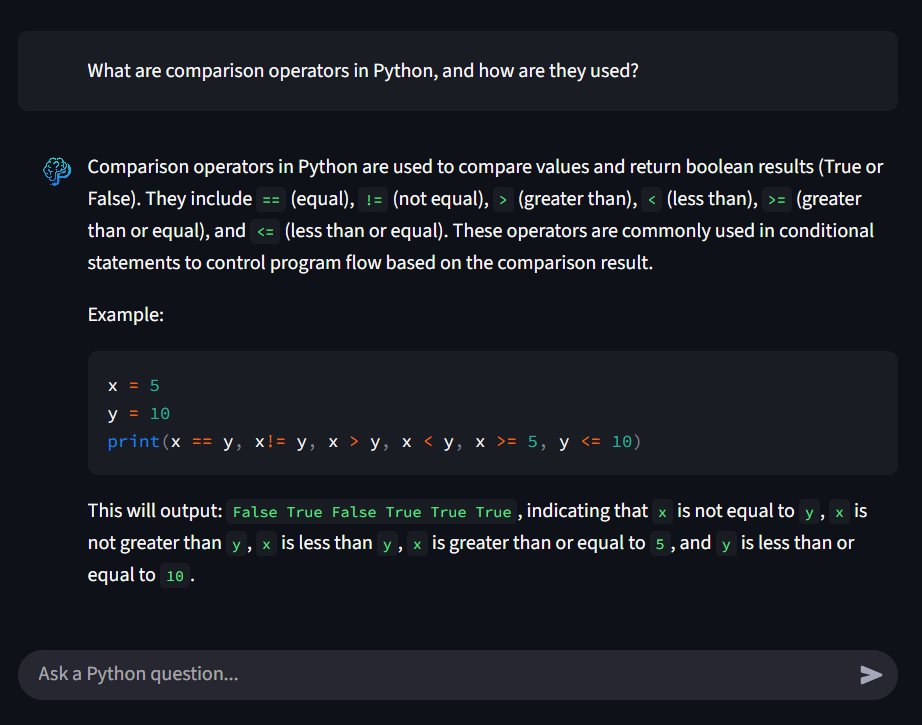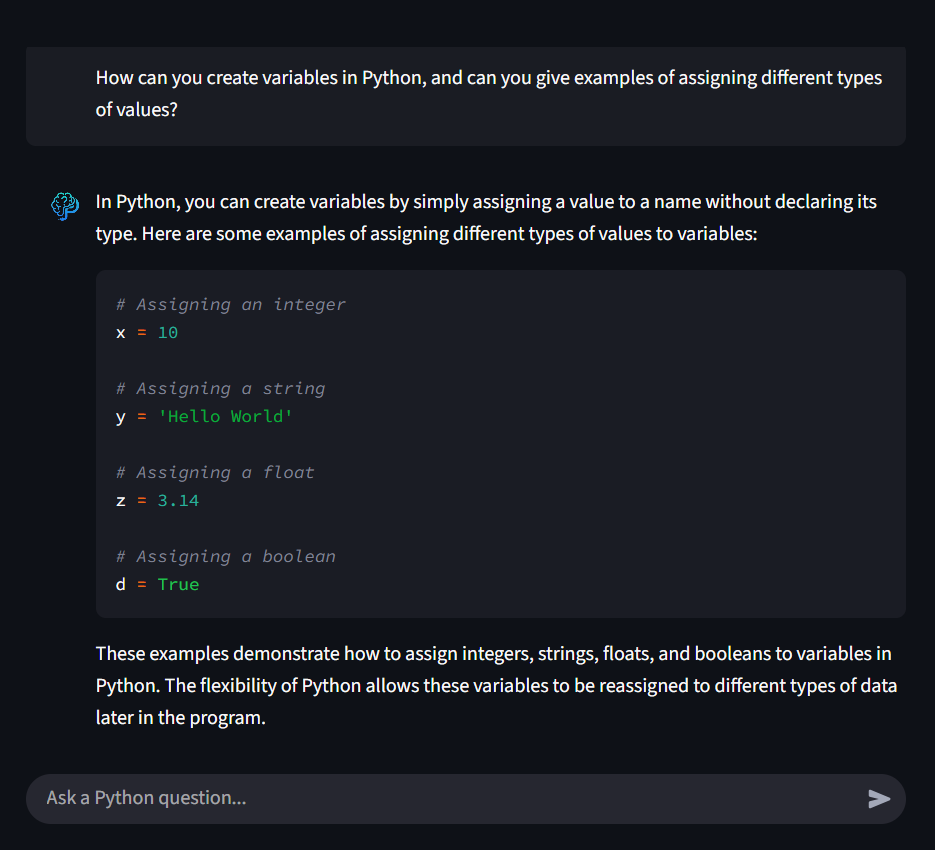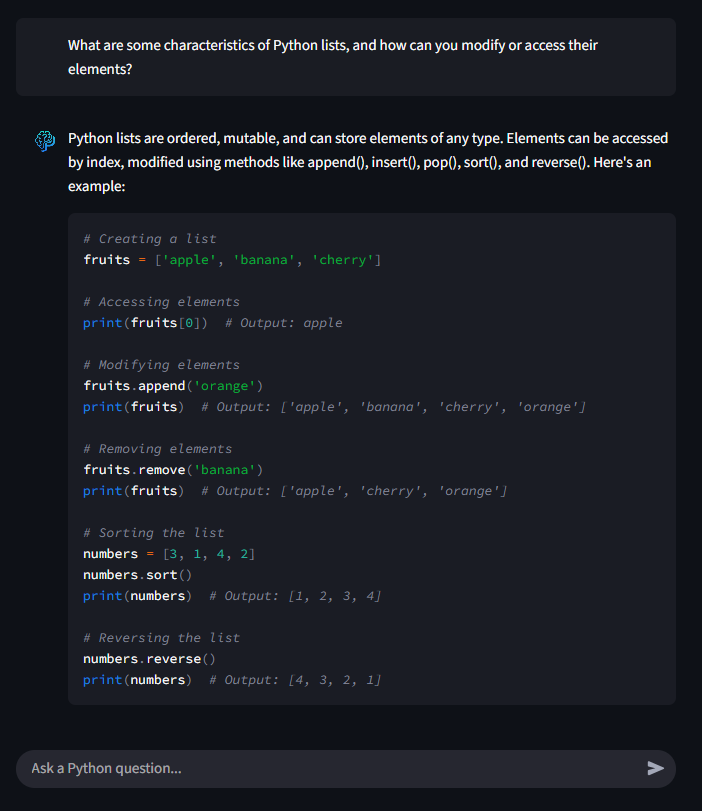